# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util

%matplotlib inline
%load_ext autoreload 
%autoreload 2
save_dir = os.path.expanduser("~/scratch/pickles/")

2024-06-10 12:04:48.624406: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [24]:
size = 6
spatial = jr.normal(jr.key(0), (10000,size,size,size))
# spatial = jr.normal(jr.key(0), (10000,size,size,size)) / ((size)**.5)**3

def plot_fourier(fourier, i_toplot=0):
    plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.pcolormesh(fourier.real[0,:,:,i_toplot])
    plt.title("real")
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(fourier.imag[0,:,:,i_toplot])
    plt.title("imag")
    plt.colorbar();
    print(fourier.shape, size//2+1)
    print(jnp.unique(fourier[0]).shape)
    print(jnp.unique(fourier.real[0]).shape)
    print(jnp.unique(jnp.abs(fourier.imag)[0]).shape)
    print(jnp.unique(fourier.real[0]).shape[0] + jnp.unique(jnp.abs(fourier.imag)[0]).shape[0], size**3, "+1 because of zero")

    all, rea, ima = (jnp.abs(fourier)**2).mean(0), (fourier.real**2).mean(0), (fourier.imag**2).mean(0)
    plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.pcolormesh(all[:,:,i_toplot])
    plt.title("var abs")
    plt.colorbar()
    plt.subplot(232)
    plt.pcolormesh(rea[:,:,i_toplot])
    plt.title("var real")
    plt.colorbar()
    plt.subplot(233)
    plt.pcolormesh(ima[:,:,i_toplot])
    plt.title("var imag")
    plt.colorbar()

    C_abs = jnp.cov(jnp.abs(fourier)[:,3,:,0].T, jnp.abs(fourier)[:,:,3,0].T)
    C_real = jnp.cov(fourier.real[:,3,:,0].T, fourier.real[:,:,3,0].T)
    C_imag = jnp.cov(fourier.imag[:,3,:,0].T, fourier.imag[:,:,3,0].T)
    plt.subplot(234)
    plt.imshow(C_abs)
    plt.title("cov abs")
    plt.colorbar()
    plt.subplot(235)
    plt.imshow(C_real)
    plt.title("cov real")
    plt.colorbar()
    plt.subplot(236)
    plt.imshow(C_imag)
    plt.title("cov imag")
    plt.colorbar()
    plt.tight_layout()

(10000, 6, 6, 4) 4
(144,)
(112,)
(105,)
217 216 +1 because of zero


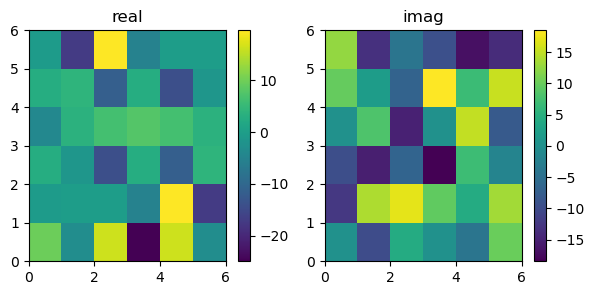

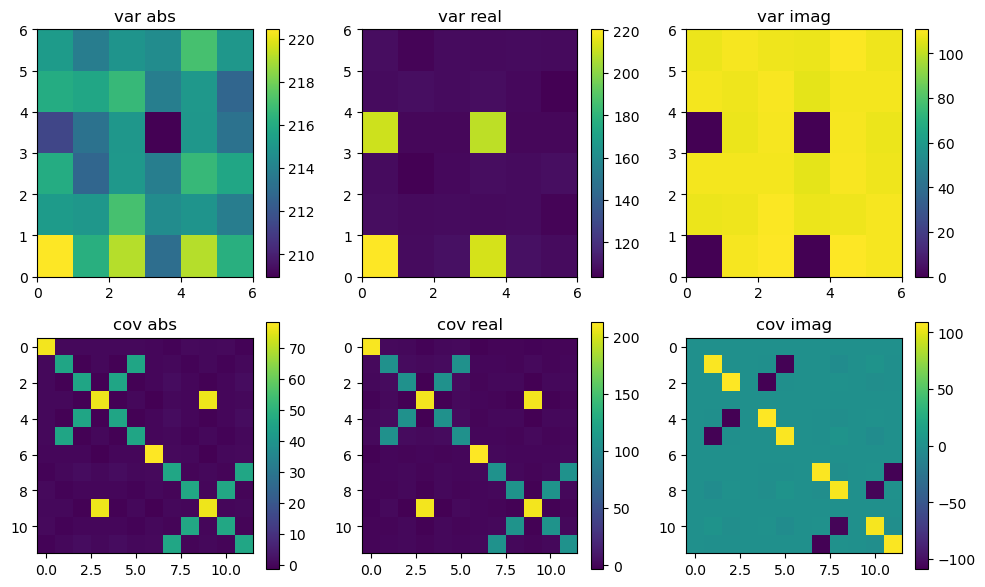

In [25]:
fourier = vmap(jnp.fft.rfftn)(spatial)
plot_fourier(fourier)

(10000, 6, 6, 4) 4
(144,)
(112,)
(105,)
217 216 +1 because of zero


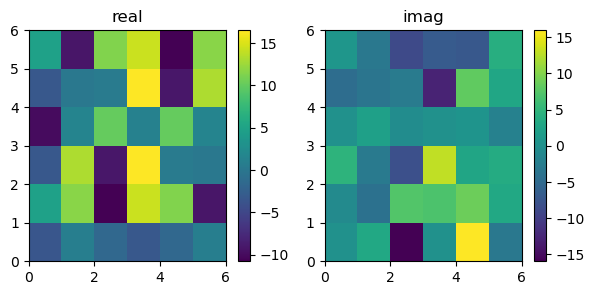

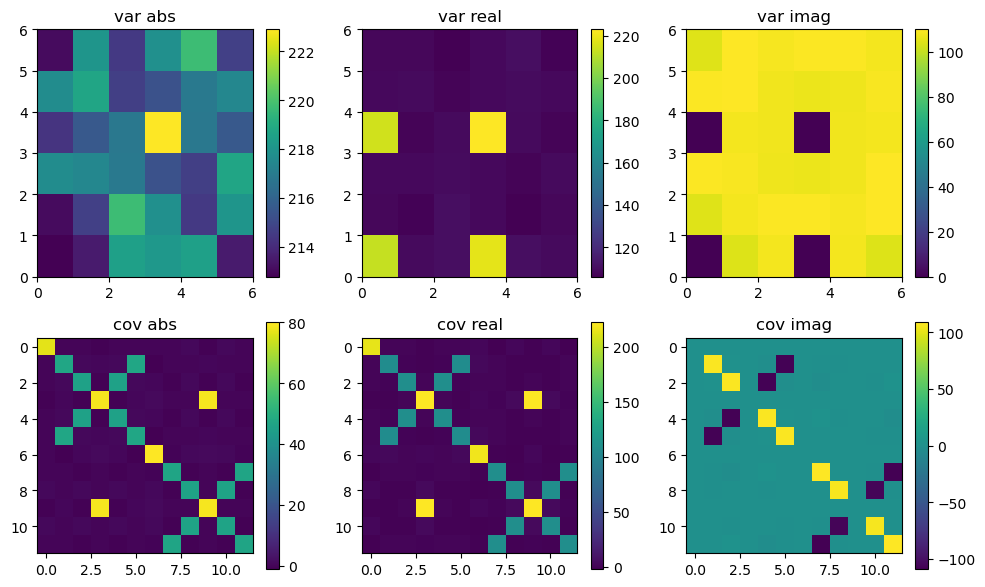

In [26]:
from montecosmo.utils import r2rfftn
fourier = vmap(r2rfftn)(spatial)
plot_fourier(fourier)

In [27]:
import math

@jit
def genrete_realx_gaussian_field_3d_k_mask(randns, dtype=jnp.float64, cdtype=jnp.complex128):
    """
    randns is an array with nc^3 standard normal vars
    """
    #import numpy as jnp    # change to jax after! fixme
    
    randns = randns.flatten()
    nc = round(randns.shape[0]**(1./3))
    
    # due to G*(f) = G(-f) symmetry, the return value will have shape nc,nc/2+1 (assuming d even)
    n = round(nc/2)+1
    
    ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype) 
    
    # grid for masking
    #grid0, grid1, grid2 = jnp.meshgrid(jnp.arange(nc), jnp.arange(nc), jnp.arange(n))
     
    # fill all non k2=0 and nyq voxels with complex number  (n-1 is nyq)
    s = (nc, nc, n-2)
    m = math.prod(s)
    
    #mask = (1 <= grid2) * (grid2 < n-1)
    pads = ((0,0), (0,0), (1,1))    # need to pad r such that it has same shape as mask, and aligns with the 1s.  # fixme, can completely remove mask!
    
    i = 0         # running index for taking dofs    for neatness, always have i= above r=
    r = randns[i:i+m].reshape(s)    # do sqrt2 just before end
    i += m
    
    ret += jnp.pad(r, pads)
    
    r = randns[i:i+m].reshape(s) * 1j
    i += m
    
    ret += jnp.pad(r, pads)
    
    # fill k2=0 nyq>k0>0  (note use of n in firt index now) only want to fill half and then will conj flip by sim.
    # we have a choice to reflect in axis 0 or 1. we chose to reflect in 1 first, 
    # so compared to 2d we just have an extra :, at the beginnign.
    # but then we'll have anthertep to reflect in 0 dimension
    # to keep track of rands easily will do reflection conj by hand.
    s = (nc, n-2, 1)
    m = math.prod(s)
    for b in [0,n-1]:                                # same methodology for when grid2=0 or nyq, o loop
        
        r = randns[i:i+m].reshape(s)
        i += m
        
        pads = [None, None, None]   # save space by updating pads[i] depending on line.
        if   b == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
        elif b == n-1: pads[2] = (n-1,0) 
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps: now we will need to pad AND mask
        # padding ofc needed for shape as above, and mask needed because we want to only reflect certain subregions of r each time)
        #pads[1] = (n,0)   # same for all of these reflections
        
        
        # real part reflections. recall r is unpadded, so simple ::-1 (in 1 index) followed by appropriate padding and 0 index works!
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (0,nc-1)
        ret += jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret += jnp.pad(r[n-1,::-1,b][None,:,None], pads) 
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (n,0)
        ret += jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret += jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
        # now do same for imaginary part
        r = randns[i:i+m].reshape(s) * 1j
        i += m
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps. - for conj
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b)
        pads[0] = (0,nc-1)
        ret -= jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret -= jnp.pad(r[n-1,::-1,b][None,:,None], pads)
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b)
        pads[0] = (n,0)
        ret -= jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret -= jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
    # now we fill the remaining lines across the 0 axis
    s = (n-2, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            r = randns[i:i+m].reshape(s)
            i += m
            
            pads = [None, None, None]   # save space by updating pads[i] depending on line.
            if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
            elif b2 == n-1: pads[2] = (n-1,0) 
            if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
            elif b1 == n-1: pads[1] = (n-1,n-2) 

            # real
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret += jnp.pad(r[::-1, b1, b2][:,None,None], pads)         #n-2:0:-1
            
            
            r = randns[i:i+m].reshape(s) * 1j
            i += m
            
            # im
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret -= jnp.pad(r[::-1, b1, b2][:,None,None], pads)
    
    # divide everyhting by sqrt(2) before doing real components
    ret /= jnp.sqrt(2)
    
    # now fill in real parts
    s = (1, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            for b0 in [0, n-1]:
                
                pads = [None, None, None]   # save space by updating pads[i] depending on line.
                if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
                elif b2 == n-1: pads[2] = (n-1,0) 
                if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
                elif b1 == n-1: pads[1] = (n-1,n-2) 
                if   b0 == 0:   pads[0] = (0,nc-1)   # pads[0] is the same throughout loop
                elif b0 == n-1: pads[0] = (n-1,n-2) 

                r = randns[i:i+m].reshape(s)
                i += m
    
                #mask = (grid0 == b0) * (grid1 == b1) * (grid2 == b2)
                ret += jnp.pad(r, pads)
            
    assert(i == nc**3)
    
    return ret #jnp.asarray(ret)


(10000, 6, 6, 4) 4
(144,)
(112,)
(105,)
217 216 +1 because of zero


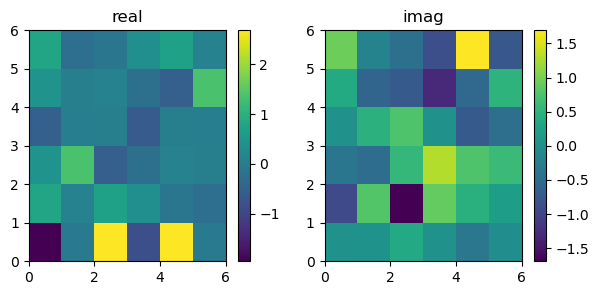

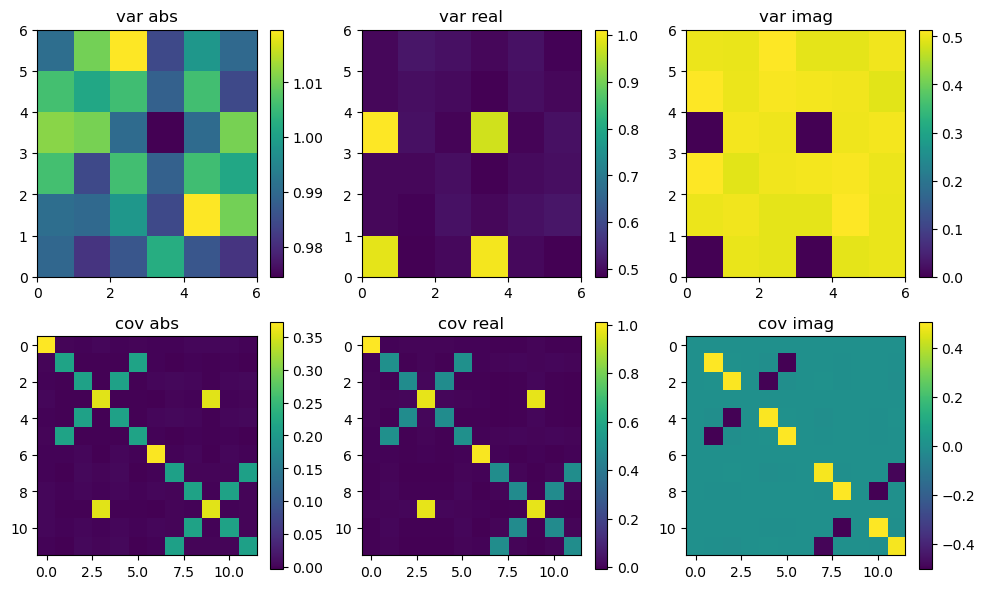

In [29]:
fourier = vmap(genrete_realx_gaussian_field_3d_k_mask)(spatial)
plot_fourier(fourier)